In [14]:
import earthaccess
import sys
import os
if r'C:\Users\attic\HLS Kelp Detection\tools' not in sys.path:
    sys.path.append(r'C:\Users\attic\HLS Kelp Detection\tools')
import kelp_tools_windows as kt
import earth_access_tools as eat
import mgrs
from pyproj import Proj, transform,Transformer
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import requests
import xml.etree.ElementTree as ET
import csv
from scipy.ndimage import binary_dilation, convolve

In [8]:
def search_bounding_box(tile_id, csv_file=r'C:\Users\attic\HLS Kelp Detection\maps\tiling_boxes.csv', clip=False):
        with open(csv_file, mode='r') as file:
            csv_reader = csv.reader(file)
            coords = None
            for row in csv_reader:
                if row[0] == tile_id:
                    coords = row[1:]
                    break
            if coords is None:
                return None
        bounding_box=(float(coords[9]), float(coords[10]), float(coords[3]),float(coords[4]))
        print(coords)
        return bounding_box

In [ ]:
eat.create_tiling_reference()

In [ ]:
search_bounding_box('11SKU')


In [63]:
def reproject_dem_to_hls(hls_path, dem_path=r'C:\Users\attic\HLS_Kelp\imagery\Socal_DEM.tiff'):
    with rasterio.open(hls_path) as dst:
        hls = dst.read()
        dem = rasterio.open(dem_path)
        # plt.figure()
        # dem_plot = dem.read()
        # plt.imshow(dem_plot[0])
        # plt.show()
        if dem.crs != dst.crs:
            reprojected_dem = np.zeros((hls.shape[1], hls.shape[2]), dtype=hls.dtype)
            reproject(
                source=dem.read(),
                destination=reprojected_dem,
                src_transform=dem.transform,
                src_crs=dem.crs,
                dst_transform=dst.transform,
                dst_crs=dst.crs,
                resampling=Resampling.bilinear)
            if reprojected_dem.any():
                return reprojected_dem
            else:
                return None
            
def compile_dem(dem_path, hls_path):
    files = os.listdir(dem_path)
    dem_files = [file for file in files if '_dem' in file]
    dem = None
    for file in dem_files:
        if(dem is None):
            dem = (reproject_dem_to_hls(hls_path=hls_path, dem_path=os.path.join(dem_path,file)))
        else:
            dem = np.where(dem == 0, reproject_dem_to_hls(hls_path=hls_path, dem_path=os.path.join(dem_path,file)), dem)
    # end main
    return dem 

def generate_land_mask(reprojected_dem, land_dilation=7, show_image=False, as_numpy=True):
    if reprojected_dem.any():
        struct = np.ones((land_dilation, land_dilation))
        reprojected_dem_gpu = np.asarray(reprojected_dem)
        land_mask = binary_dilation(reprojected_dem_gpu > 0, structure=struct)
        if as_numpy:
            land_mask = np.array(land_mask)
        if show_image:
            plt.figure(figsize=(6, 6))
            if as_numpy:
                plt.imshow(land_mask, cmap='gray')
            else:
                plt.imshow(np.array(land_mask))
            plt.show()
        return land_mask
    else:
        print("Something failed, you better go check...")
        sys.exit()

def create_land_mask(hls_path, dem_path='/mnt/c/Users/attic/HLS_Kelp/imagery/Socal_DEM.tiff', show_image=False, as_numpy=True):
    reprojected_dem = compile_dem(dem_path,hls_path)
    return generate_land_mask(reprojected_dem, show_image=show_image, as_numpy=as_numpy)

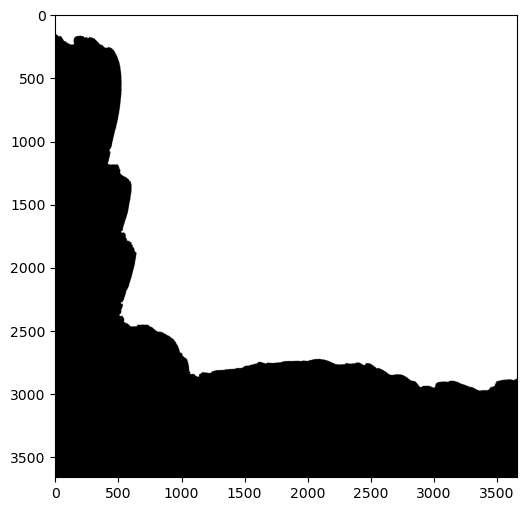

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [64]:
hls_path = r'C:\Users\attic\HLS Kelp Detection\imagery\tiles\10SGD\HLS.L30.T10SGD.2018026T183427.v2.0\HLS.L30.T10SGD.2018026T183427.v2.0.B02.tif'
tile = '10SGD'
dem_path = rf'C:\Users\attic\HLS Kelp Detection\imagery\tiles\{tile}\dem'

create_land_mask(hls_path, dem_path=dem_path, show_image=True, as_numpy=True)

